In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import osimport os
import re
import lyricsgenius

# Function to check prerequisites and install packages if not already installed
def install_packages():
    try:
        import lyricsgenius
    except ImportError:
        import subprocess
        subprocess.run(['pip', 'install', 'lyricsgenius'], check=True)

# Setup API
def setup_genius():
    token = '' # Ensure you have set the environment variable appropriately
    genius = lyricsgenius.Genius(token)
    genius.remove_section_headers = True
    genius.timeout = 30
    genius.skip_non_songs = True
    genius.excluded_terms = ["(Remix)", "(Live)", "(Radio Edit)"]
    return genius

# Fetch lyrics for a given artist
def fetch_lyrics(genius, artist_name, max_songs=10):
    artist = genius.search_artist(artist_name, max_songs=max_songs, sort='popularity')
    return [song.lyrics for song in artist.songs] if artist else []

# Save lyrics to a file
def save_lyrics(genius, file_path):
    genres_artists = {
        "Pop": [
            "Michael Jackson", "Madonna", "Beyoncé", "Lady Gaga", "Taylor Swift",
            "Justin Bieber", "Katy Perry", "Britney Spears", "Adele", "Bruno Mars"
        ],
        "Rock": [
            "Elvis Presley", "Freddie Mercury", "David Bowie", "Jim Morrison", "Mick Jagger",
            "Bruce Springsteen", "John Lennon", "Paul McCartney", "Robert Plant", "Kurt Cobain"
        ],
        "Jazz": [
            "Ella Fitzgerald", "Billie Holiday", "Louis Armstrong", "Nina Simone", "Sarah Vaughan",
            "Chet Baker", "John Coltrane", "Miles Davis", "Tony Bennett", "Duke Ellington"
        ],
        "Rap": [
            "Tupac Shakur", "Notorious B.I.G.", "Jay-Z", "Eminem", "Kanye West",
            "Nicki Minaj", "Snoop Dogg", "Kendrick Lamar", "Lil Wayne", "Drake"
        ],
        "Country": [
            "Johnny Cash", "Dolly Parton", "Willie Nelson", "Garth Brooks", "Shania Twain",
            "Hank Williams", "Carrie Underwood", "Kenny Rogers", "Miranda Lambert", "Tim McGraw"
        ],
        "R&B": [
            "Aretha Franklin", "Stevie Wonder", "Mariah Carey", "Whitney Houston", "Usher",
            "Alicia Keys", "Ray Charles", "Mary J. Blige", "R. Kelly", "Prince"
        ],
        "Blues": [
            "B.B. King", "Muddy Waters", "John Lee Hooker", "Ray Charles", "Etta James",
            "Robert Johnson", "Buddy Guy", "Howlin’ Wolf", "Janis Joplin", "Lead Belly"
        ],
        "Electronic/Dance": [
            "Daft Punk", "Calvin Harris", "Avicii", "Deadmau5", "David Guetta",
            "Skrillex", "Tiësto", "Diplo", "Marshmello", "Kygo"
        ],
        "Reggae": [
            "Bob Marley", "Peter Tosh", "Bunny Wailer", "Gregory Isaacs", "Jimmy Cliff",
            "Toots Hibbert", "Damian Marley", "Sean Paul", "Shaggy", "Buju Banton"
        ]
    }

    with open(file_path, 'w', encoding='utf-8') as file:
        for genre, artists in genres_artists.items():
            for artist in artists:
                lyrics = fetch_lyrics(genius, artist)
                for lyric in lyrics:
                    file.write(f"[s:genre]{genre}[e:genre][s:lyrics]{lyric}[e:lyrics]\n")

# Clean lyrics from the file
def clean_lyrics(file_path, output_path):
    # Regex pattern to find and remove the undesired parts more aggressively
    contributors_pattern = re.compile(r'\d+\s*Contributors.*?Lyrics', re.DOTALL)
    # Match "Embed" followed by any number, ignoring anything up to the next tag or end of line
    embed_pattern = re.compile(r'\d+\s*Embed.*?(?=\[|$)', re.DOTALL)
    
    # Read the input file
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.readlines()

    # Clean each line using the regex pattern
    cleaned_content = [re.sub(contributors_pattern, '', line) for line in content]
    cleaned_text = [re.sub(embed_pattern, '', line) for line in cleaned_content]

    # Write the cleaned data to a new file
    with open(output_path, 'w', encoding='utf-8') as file:
        file.writelines(cleaned_text)

    print("Lyrics cleaned and saved to:", output_path)

def clean_lyric_content(lyric_text):
    # Remove unwanted metadata like contributor lists and translation notes
    lyric_text = re.sub(r'\d+\s*ContributorsTranslations.*?Lyrics', '', lyric_text, flags=re.DOTALL)
    # Match "Embed" followed by any number, ignoring anything up to the next tag or end of line
    embed_pattern = re.compile(r'\d+\s*Embed.*?(?=\[|$)', re.DOTALL)
    lyric_text = re.sub(embed_pattern, '', lyric_text)
    lyric_text = re.sub(r'\[.*?\](?!\[s:|\[e:)', '', lyric_text)  # Remove all brackets that do not start structural tags

    return lyric_text.strip()

# Main execution flow
if __name__ == "__main__":
    install_packages()
    genius_api = setup_genius()
    lyrics_file_path = ''
    if not os.path.exists(lyrics_file_path):
        print('Start using Genius API to load the training data...')
        save_lyrics(genius_api, lyrics_file_path)

    clean_lyrics_path = ''
    clean_lyrics(lyrics_file_path, clean_lyrics_path)
    print(f"Lyrics cleaned and saved to: {clean_lyrics_path}")


In [ ]:
import re

if not os.path.exists('/kaggle/working/cleaned_lyrics_data2.txt'):
    def clean_lyrics(text):
        # Remove all double quotes
        text = text.replace('"', '')

        # Remove or replace special characters if they are not ASCII
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Remove non-ASCII characters

        # Replace three or more new lines with exactly two new lines
        text = re.sub(r'\n{3,}', '\n\n', text)

        return text

    # Example usage
    with open('/kaggle/working/cleaned_lyrics_data.txt', 'r', encoding='utf-8') as file:
        data = file.read()

    clean_data = clean_lyrics(data)

    # Write the cleaned data back to a file
    with open('/kaggle/working/cleaned_lyrics_data2.txt', 'w', encoding='utf-8') as file:
        file.write(clean_data)


2024-04-26 07:34:57.856526: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 07:34:57.856657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 07:34:57.979882: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warni

Epoch,Training Loss,Validation Loss
1,85.963500,98.477386
2,82.679800,94.437271
3,75.871100,87.531631
4,64.673900,77.399925
5,48.390800,62.715263
6,27.005200,39.203724
7,13.742100,17.035408
8,8.077400,9.055860
9,5.368900,5.638123
10,4.450500,5.667084


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


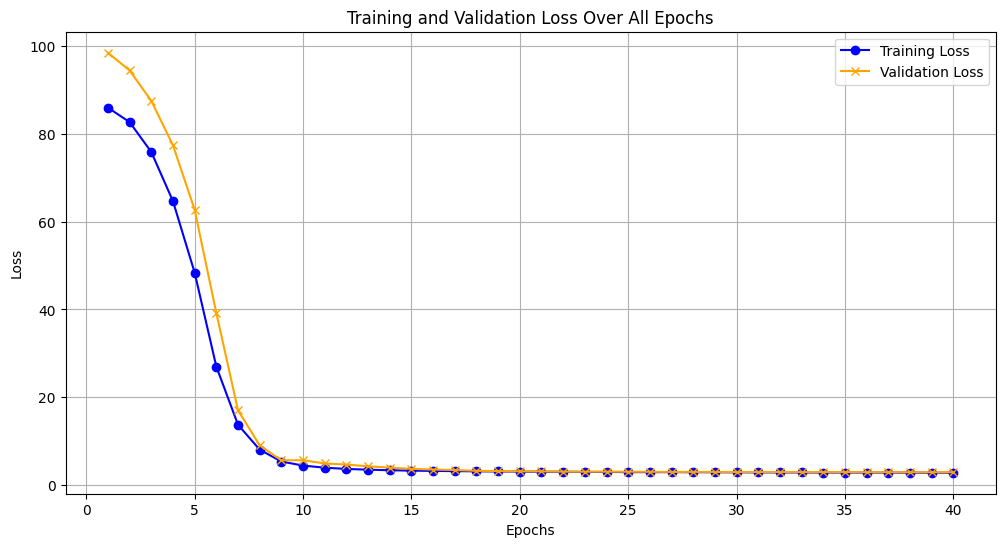

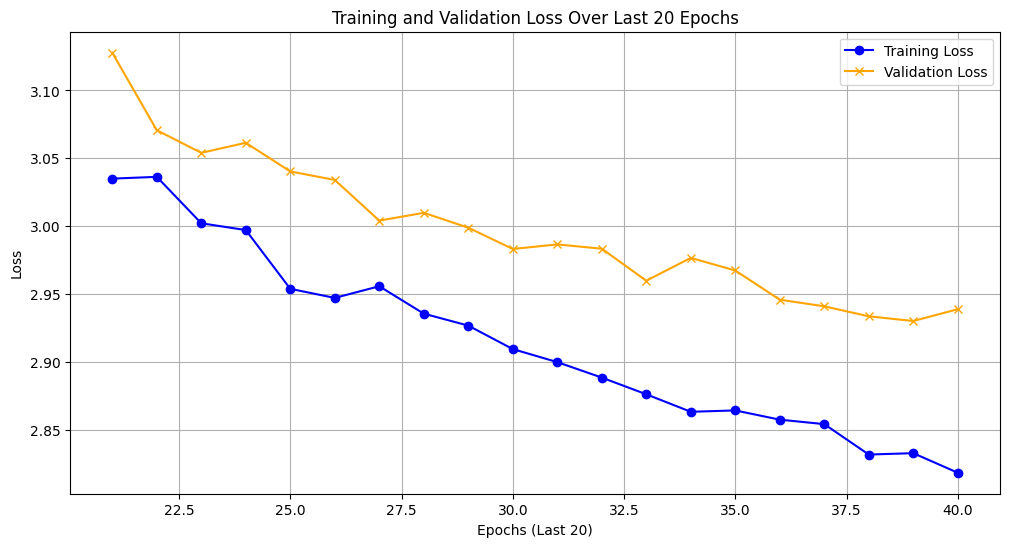

In [1]:
from datasets import Dataset
from transformers import GPT2TokenizerFast
import torch
import os
import re
import numpy as np
from transformers import GPT2LMHeadModel, Trainer, TrainingArguments
from transformers import AdamW, get_scheduler, EarlyStoppingCallback

os.environ['WANDB_DISABLED'] = 'true'

if os.path.exists('/kaggle/input/more-genres/final_cleaned_lyrics.txt'):
    file_path = '/kaggle/input/more-genres/final_cleaned_lyrics.txt'
else:
    file_path = '/kaggle/working/cleaned_lyrics_data2.txt'

from transformers import TrainerCallback

class PrintLossCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            print(f"Step: {state.global_step}, Training Loss: {logs.get('loss', 'N/A')}, Validation Loss: {logs.get('eval_loss', 'N/A')}")

class MetricsLoggerCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.epochs = []

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        # Save evaluation loss after each evaluation
        if metrics and 'eval_loss' in metrics:
            self.eval_losses.append(metrics['eval_loss'])

    def on_log(self, args, state, control, logs=None, **kwargs):
        # Save training loss after each logging step
        if logs and 'loss' in logs:
            self.train_losses.append(logs['loss'])
            self.epochs.append(state.epoch)  # Save the current epoch

    def get_metrics(self):
        return self.epochs, self.train_losses, self.eval_losses

class LyricsDataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, file_path, block_size):
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()

        # Split the content into lyric blocks
        self.lyric_blocks = re.findall(r'\[s:genre\].*?\[e:genre\]\[s:lyrics\](.*?)\[e:lyrics\]', content, re.DOTALL)
        if not self.lyric_blocks:
            raise ValueError("No lyric blocks found. Check the format of the input file.")

        self.examples = []
        for block in self.lyric_blocks:
            bpe_tokens = tokenizer(block.strip(), truncation=True, max_length=block_size, padding="max_length", return_tensors="pt")
            self.examples.append({
                'input_ids': bpe_tokens['input_ids'][0],
                'attention_mask': bpe_tokens['attention_mask'][0],
                'labels': bpe_tokens['input_ids'][0]  
            })

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        return self.examples[i]
    
# Load tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
special_tokens_dict = {'additional_special_tokens': ['[s:genre]', '[e:genre]', '[s:lyrics]', '[e:lyrics]']}
tokenizer.add_special_tokens(special_tokens_dict)
tokenizer.pad_token = tokenizer.eos_token

# Create dataset
block_size = 160 # Adjust based on your GPU memory
dataset = LyricsDataset(tokenizer, file_path, block_size)

from sklearn.model_selection import train_test_split

train_dataset, eval_dataset = train_test_split(dataset, test_size=0.1)  # 10% for validation

model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))


training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch", 
    save_strategy="epoch", 
    logging_strategy="epoch",              
    num_train_epochs=40,
    per_device_train_batch_size=36,
    per_device_eval_batch_size=36,
    warmup_steps=500,
    weight_decay=0.001,
    logging_dir='./logs',
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='loss',
    greater_is_better=False
)

optimizer = AdamW(model.parameters(), lr=5e-6)

# Initialize the learning rate scheduler
num_training_steps = len(train_dataset) * training_args.num_train_epochs
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=num_training_steps,
)

metrics_logger = MetricsLoggerCallback()
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    optimizers=(optimizer, lr_scheduler),
    callbacks=[metrics_logger, EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
trainer.train()

# Save the model and configuration
model.save_pretrained('/kaggle/working/results/best/')

tokenizer.save_pretrained('./results/tokenizer/')

import json

# Save TrainingArguments to a JSON file
args_dict = training_args.to_dict()  # Convert TrainingArguments to a dictionary
with open('/kaggle/working/results/training_args.json', 'w') as f:
    json.dump(args_dict, f, indent=4)

    
import matplotlib.pyplot as plt

# Retrieve logged metrics
epochs, train_losses, eval_losses = metrics_logger.get_metrics()

# Create the plot
if epochs:
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o', color='blue')
    plt.plot(epochs, eval_losses, label='Validation Loss', marker='x', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over All Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
    if len(epochs) > 20:  # Check if there are at least 20 epochs
        zoom_range_start = -20  # Last 20 epochs
        plt.figure(figsize=(12, 6))
        plt.plot(epochs[zoom_range_start:], train_losses[zoom_range_start:], label='Training Loss', marker='o', color='blue')
        plt.plot(epochs[zoom_range_start:], eval_losses[zoom_range_start:], label='Validation Loss', marker='x', color='orange')
        plt.xlabel('Epochs (Last 20)')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Last 20 Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()
    
else:
    print("No data to plot. Check the data collection process.")

In [2]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import torch
import re

# Load the model and tokenizer
model = GPT2LMHeadModel.from_pretrained('/kaggle/working/results/best')
tokenizer = GPT2TokenizerFast.from_pretrained('/kaggle/working/results/tokenizer')

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def generate_lyrics(genre, prompt, min_length=200, max_length=600):
    genre_context = f"[s:genre]{genre}[e:genre]"
    lyrics_context = f"[s:lyrics]"
    full_prompt = f"{genre_context}{lyrics_context} {prompt}"
    
    input_ids = tokenizer.encode(full_prompt, return_tensors='pt').to(device)

    eos_token_id = tokenizer.encode('[e:lyrics]', add_special_tokens=False)[0]

    output_ids = model.generate(
        input_ids,
        max_length=max_length,
        min_length=min_length,
        top_k=50,
        top_p=0.9,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=eos_token_id,
        no_repeat_ngram_size=2,
        do_sample=True,
        temperature=0.8
    )

    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=False)
    clean_text = generated_text.split('[e:lyrics]')[0]  # Strip everything after end lyrics tag
    clean_text = re.sub(r'\[s:genre\].*?\[e:genre\]', '', clean_text)  # Remove genre tags
    clean_text = clean_text.replace(lyrics_context, "").strip()  # Remove lyrics start tag

    return clean_text

genres = ["Pop", "Rap", "Rock", "Jazz"]
prompt = False
initial_prompt = ''
for genre in genres:
    if prompt:
        initial_prompt = input(f'Enter the first few lines for {genre} generation, or leave empty for the model to decide:\n')
    generated_lyrics = generate_lyrics(genre, initial_prompt)
    clean_text = re.sub(r'\[s:genre\]', '', generated_lyrics) # Remove [s:genre] tags
    clean_text = re.sub(r'\<|endoftext|>', '', clean_text)
    clean_text = re.sub(r'\[sgenre\]', '', clean_text) 
    clean_text = re.sub(r'\[egenre\]', '', clean_text) 
    clean_text = re.sub(r'\[e:genre\]', '', clean_text) 
    clean_text = re.sub(r'\||', '', clean_text)
    clean_text = re.sub(r':', '', clean_text)

    print(f"Generated Lyrics for {genre}:\n\n",clean_text + '\n')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Generated Lyrics for Pop:

 ____
I'm going to be the best
And I'm gonna be a baby
Ain't no need for a new clothes
With the new style, you can look the part

Just like the last time I saw you
The way I look, I'll be fine
But I don't need to change
Like the old days, we all know
You look what you do
Yeah, there's a way to keep the change going
Got to stick to the plan
Get the whole thing up and running
That's what I do for the money
Well, yeah, and I feel good about the way
Now I can go to bed at the same time
Let's get to work
We all have a lot to do with each other
Work and play together, let's go on
It's all part of the fun
So don that, don the things, all you want to hear
Is the love I need, the life I want
Yes, it's part and all
Everything I've ever known
Love is a gift
There's no limit to what we can do, okay
Don't let it get you down
Give it all to me, baby, just let me know that it is in your hands
For I have been lovin' you, my little angel
Since your name is on the cross
Make s

In [3]:
from IPython.display import FileLink
!zip -r file.zip /kaggle/working/results/best/ /kaggle/working/results/tokenizer/
FileLink(r'file.zip')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: kaggle/working/results/best/ (stored 0%)
  adding: kaggle/working/results/best/model.safetensors (deflated 7%)
  adding: kaggle/working/results/best/config.json (deflated 51%)
  adding: kaggle/working/results/best/generation_config.json (deflated 24%)
  adding: kaggle/working/results/tokenizer/ (stored 0%)
  adding: kaggle/working/results/tokenizer/merges.txt (deflated 53%)
  adding: kaggle/working/results/tokenizer/tokenizer.json (deflated 72%)
  adding: kaggle/working/results/tokenizer/vocab.json (deflated 59%)
  adding: kaggle/working/results/tokenizer/added_tokens.json (deflated 45%)
  adding: kaggle/working/results/tokenizer/tokenizer_config.json (deflated 77%)
  adding: kaggle/working/results/tokenizer/special_tokens_map.json (deflated 78%)


/kaggle/working/file.zip